In [268]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Preparing Data

In [188]:
import torch.nn as nn
import torch.nn.functional as F

In [189]:
transform=transforms.Compose([transforms.ToTensor()])

In [190]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [191]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [192]:
data=data.reshape(data.shape[0],-1) 

In [193]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [194]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [195]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [196]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)

In [197]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# A2 . Logistic Regression 

###  Binary Classification Task


In [198]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [199]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [200]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [201]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [202]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [203]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [204]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [205]:
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220


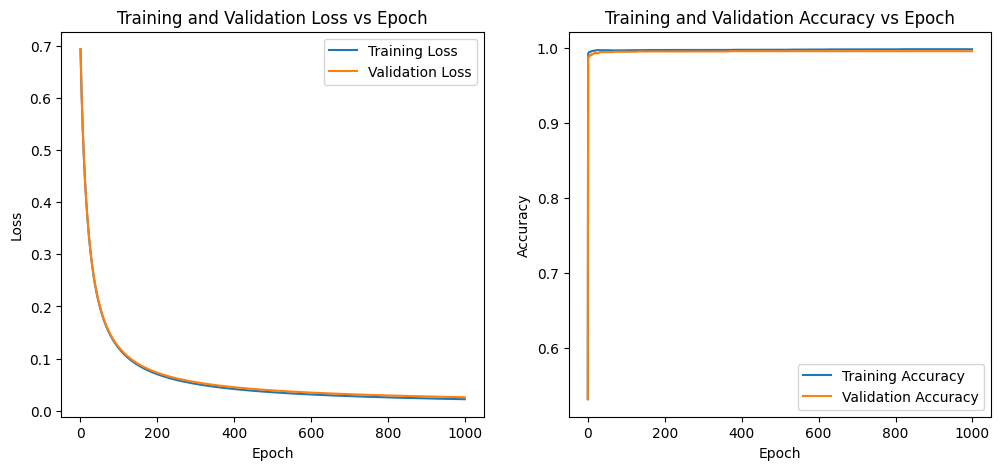

In [206]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [207]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [208]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


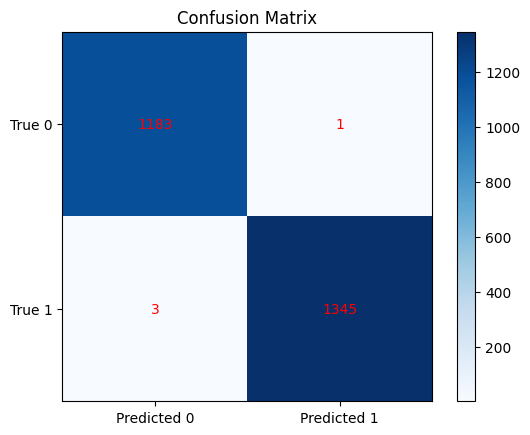

In [209]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()

# A3.Softmax Regression

### Multi-class Classification Task

In [210]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

In [211]:
def cross_entropy_loss(predictions, targets):
    num_samples = predictions.shape[0]
    log_probs = -torch.log(predictions[range(num_samples), targets])
    loss = torch.mean(log_probs)
    return loss

In [212]:
number_of_features=28*28 
number_of_classes=10

W_multi=torch.zeros((number_of_features,number_of_classes),requires_grad=True)
b_multi=torch.zeros((1,number_of_classes),requires_grad=True)

lr=0.01
num_epochs=10

In [213]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [214]:
for epoch in range(num_epochs):
    total_loss=0
    total_correct=0
    total=0
    for images,labels in training_loader:
        trained_data=images.view(-1,28*28)

        scores=linear_output(trained_data,W_multi,b_multi)
        training_predictions=softmax(scores)

        loss=cross_entropy_loss(training_predictions,labels)
        loss.backward()

        predections=torch.argmax(training_predictions,dim=1)

        total_correct+=(predections==labels).sum().item()
        total+=labels.size(0)
        total_loss+=loss.item()*labels.size(0)

        with torch.no_grad():
            W_multi-=lr*W_multi.grad
            b_multi-=lr*b_multi.grad
        W_multi.grad.zero_()
        b_multi.grad.zero_()


    training_loss=total_loss/total
    training_accuracy=total_correct/total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)


    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        total_val=0
        for val_images,val_labels in validation_loader:
            val_trained_data=val_images.view(-1,28*28)

            val_scores=linear_output(val_trained_data,W_multi,b_multi)
            val_predictions=softmax(val_scores)

            val_loss=cross_entropy_loss(val_predictions,val_labels)

            val_predections=torch.argmax(val_predictions,dim=1)

            total_val_correct+=(val_predections==val_labels).sum().item()
            total_val+=val_labels.size(0)
            total_val_loss+=val_loss.item()*val_labels.size(0)

        validation_loss=total_val_loss/total_val
        validation_accuracy=total_val_correct/total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

Epoch [1/10], Training Loss: 1.1712, Validation Loss: 0.7674
Epoch [2/10], Training Loss: 0.6550, Validation Loss: 0.5945
Epoch [3/10], Training Loss: 0.5442, Validation Loss: 0.5240
Epoch [4/10], Training Loss: 0.4907, Validation Loss: 0.4849
Epoch [5/10], Training Loss: 0.4581, Validation Loss: 0.4590
Epoch [6/10], Training Loss: 0.4353, Validation Loss: 0.4399
Epoch [7/10], Training Loss: 0.4184, Validation Loss: 0.4262
Epoch [8/10], Training Loss: 0.4051, Validation Loss: 0.4145
Epoch [9/10], Training Loss: 0.3945, Validation Loss: 0.4050
Epoch [10/10], Training Loss: 0.3855, Validation Loss: 0.3975


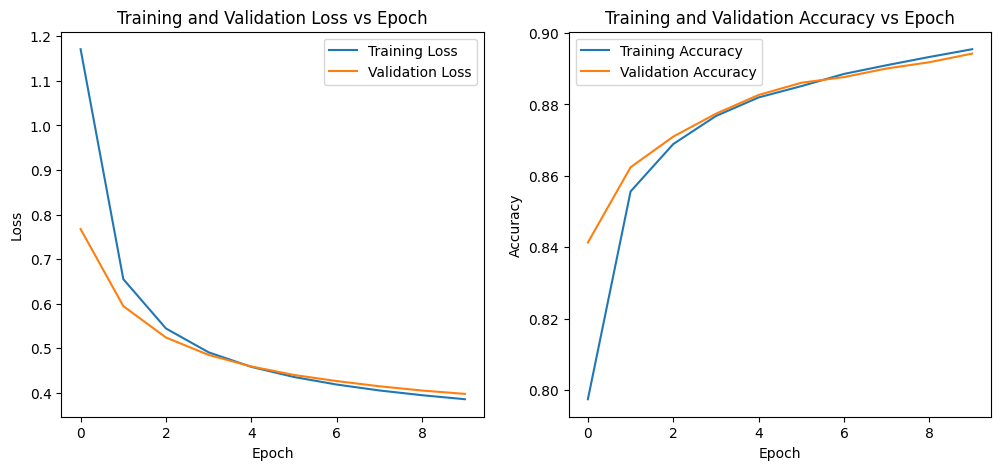

In [215]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

In [216]:
confusion_matrix_multi=torch.zeros(number_of_classes,number_of_classes,dtype=torch.int32)
total_correct=0
total=0
with torch.no_grad():
    for test_images,test_labels in testing_loader:
        test_trained_data=test_images.view(-1,28*28)

        test_scores=linear_output(test_trained_data,W_multi,b_multi)
        test_predictions=softmax(test_scores)

        test_predections=torch.argmax(test_predictions,dim=1)

        total_correct+=(test_predections==test_labels).sum().item()
        total+=test_labels.size(0)

        for true_label, pred_label in zip(test_labels, test_predections):
            confusion_matrix_multi[int(true_label.item()), int(pred_label.item())] += 1
test_accuracy=total_correct/total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 89.42%


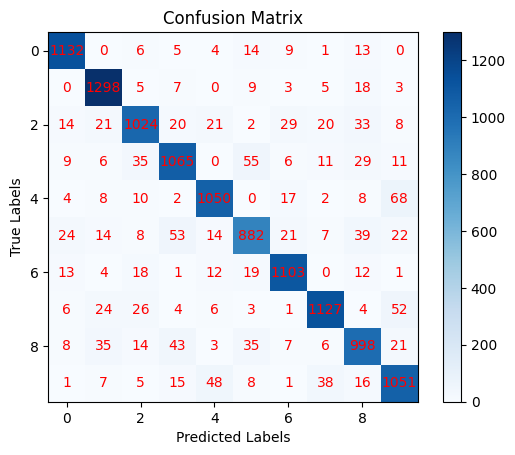

In [218]:
plt.imshow(confusion_matrix_multi, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(number_of_classes):
    for j in range(number_of_classes):
        plt.text(j, i, confusion_matrix_multi[i, j].item(), ha='center', va='center', color='red')

plt.show()

In [219]:
accuracy_per_class=confusion_matrix_multi.diagonal()/confusion_matrix_multi.sum(dim=1)
for i, accuracy in enumerate(accuracy_per_class):
    print(f'Accuracy for class {i}: {accuracy.item()*100:.2f}%')


Accuracy for class 0: 95.61%
Accuracy for class 1: 96.29%
Accuracy for class 2: 85.91%
Accuracy for class 3: 86.80%
Accuracy for class 4: 89.82%
Accuracy for class 5: 81.37%
Accuracy for class 6: 93.24%
Accuracy for class 7: 89.94%
Accuracy for class 8: 85.30%
Accuracy for class 9: 88.32%


## Neural Network

In [220]:
class ForwardNN(nn.Module):
    def __init__(self,input=784,firstL=256,secondL=128,output=10):
        super(ForwardNN,self).__init__()
        self.first=nn.Linear(input,firstL)
        self.second=nn.Linear(firstL,secondL)
        self.third=nn.Linear(secondL,output)
        nn.init.xavier_uniform_(self.first.weight)
        nn.init.xavier_uniform_(self.second.weight)
        nn.init.xavier_uniform_(self.third.weight)
    def forward(self,x):
        x=F.relu(self.first(x))
        x=F.relu(self.second(x))
        x=self.third(x)
        return x

In [221]:
def calculate_accuracy(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [222]:
def train(model,epochs):
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    tl,vl = [],[]
    ta,va=[],[]
    batch_losses=[]
    
    for epoch in range(epochs):
        model.train()  
        curloss=0.0
        batch_loss=[]
        
        for inputs, labels in training_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            opt.zero_grad()
            loss.backward() #calculate grad  
            opt.step() # update weights 
            curloss += loss.item() * inputs.size(0)
            batch_loss.append(loss.item())
        batch_losses.append(batch_loss)
        epoch_train_loss =curloss/len(training_loader.dataset)
        
        #validation
        model.eval()
        valloss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valloss += loss.item() * inputs.size(0)
        epoch_val_loss = valloss / len(validation_loader.dataset)
        train_acc =calculate_accuracy(model, training_loader)
        val_acc =calculate_accuracy(model, validation_loader)
        tl.append(epoch_train_loss)
        vl.append(epoch_val_loss)
        ta.append(train_acc)
        va.append(val_acc) 
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    return tl,vl,ta,va,batch_losses

In [223]:
model = ForwardNN(input=784, firstL=256, secondL=128, output=10)
tl,vl,ta,va,batch=train(model,50)

Epoch [1/50] Train Loss: 1.1610, Val Loss: 0.5568, Train Acc: 86.42%, Val Acc: 86.11%
Epoch [2/50] Train Loss: 0.4467, Val Loss: 0.4014, Train Acc: 89.38%, Val Acc: 89.12%
Epoch [3/50] Train Loss: 0.3567, Val Loss: 0.3483, Train Acc: 90.72%, Val Acc: 90.45%
Epoch [4/50] Train Loss: 0.3161, Val Loss: 0.3191, Train Acc: 91.47%, Val Acc: 91.22%
Epoch [5/50] Train Loss: 0.2902, Val Loss: 0.2963, Train Acc: 92.02%, Val Acc: 91.74%
Epoch [6/50] Train Loss: 0.2702, Val Loss: 0.2839, Train Acc: 92.67%, Val Acc: 92.02%
Epoch [7/50] Train Loss: 0.2536, Val Loss: 0.2683, Train Acc: 93.06%, Val Acc: 92.37%
Epoch [8/50] Train Loss: 0.2394, Val Loss: 0.2541, Train Acc: 93.51%, Val Acc: 92.70%
Epoch [9/50] Train Loss: 0.2270, Val Loss: 0.2422, Train Acc: 93.93%, Val Acc: 93.07%
Epoch [10/50] Train Loss: 0.2148, Val Loss: 0.2360, Train Acc: 94.00%, Val Acc: 93.10%
Epoch [11/50] Train Loss: 0.2043, Val Loss: 0.2229, Train Acc: 94.36%, Val Acc: 93.64%
Epoch [12/50] Train Loss: 0.1946, Val Loss: 0.2160, 

In [224]:
test_acc = calculate_accuracy(model, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 96.75%


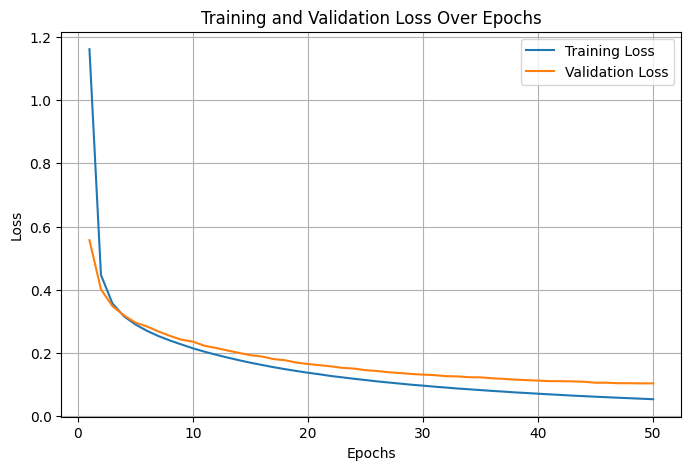

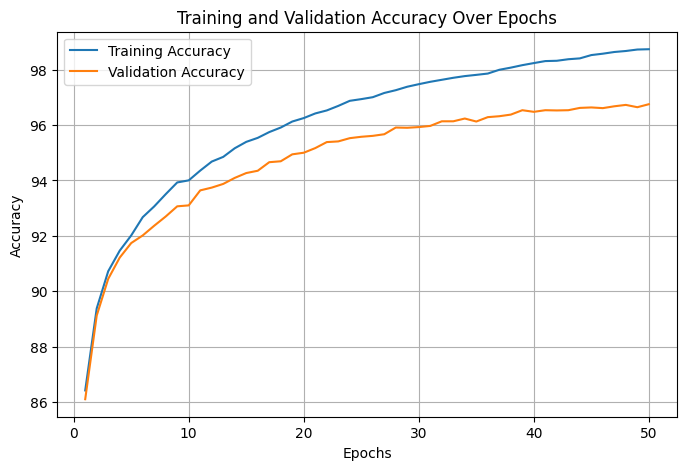

In [225]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

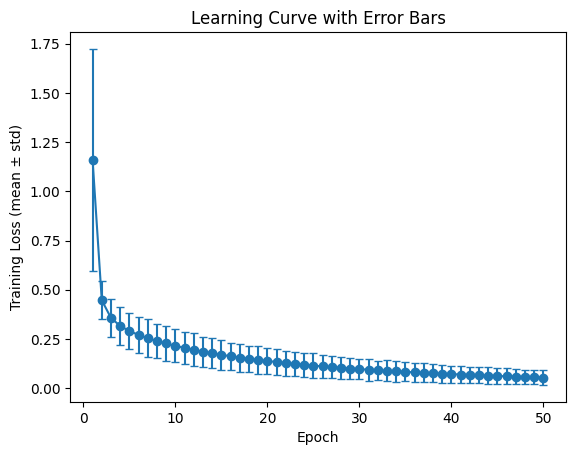

In [226]:
train_mean = [np.mean(b) for b in batch]
train_std  = [np.std(b) for b in batch]
epochs_range = range(1, len(train_mean)+1)

plt.errorbar(epochs_range, train_mean, yerr=train_std, fmt='-o', capsize=3)
plt.title("Learning Curve with Error Bars")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (mean ± std)")
plt.show()

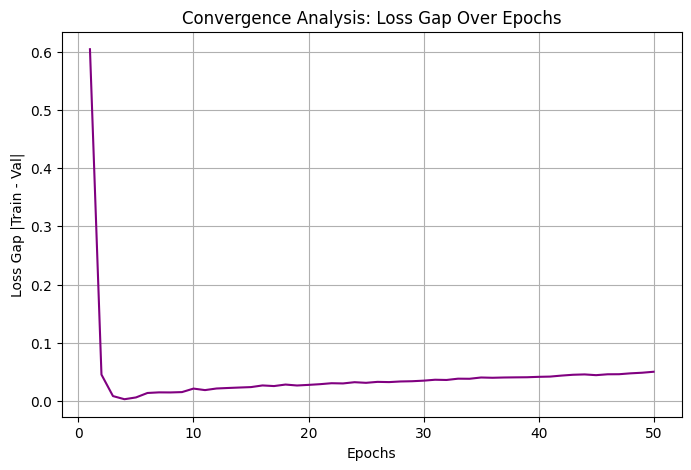

In [227]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

## Comprehensive Analysis

## Part C: Comprehensive Analysis

In [234]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for X, y in train_loader:
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / total
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                outv = model(Xv)
                lossv = criterion(outv, yv)
                val_loss += lossv.item() * Xv.size(0)
                _, predv = torch.max(outv, 1)
                val_correct += (predv == yv).sum().item()
                val_total += yv.size(0)
        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}] "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
    return train_losses, val_losses, train_accs, val_accs

# C1. Hyperparameter Analysis

## Learning Rate Analysis

In [235]:
# learning rate analysis
learning_rates = [0.001, 0.01, 0.1, 1.0]
results_lr = {}


==== Training with Learning Rate = 0.001 ====
Epoch [1/10] Train Loss=2.1546, Val Loss=1.9906, Train Acc=31.23%, Val Acc=50.49%
Epoch [2/10] Train Loss=1.8196, Val Loss=1.6453, Train Acc=60.13%, Val Acc=66.42%
Epoch [3/10] Train Loss=1.4675, Val Loss=1.3056, Train Acc=70.44%, Val Acc=72.99%
Epoch [4/10] Train Loss=1.1628, Val Loss=1.0476, Train Acc=75.97%, Val Acc=77.40%
Epoch [5/10] Train Loss=0.9476, Val Loss=0.8748, Train Acc=79.45%, Val Acc=80.38%
Epoch [6/10] Train Loss=0.8041, Val Loss=0.7590, Train Acc=81.88%, Val Acc=82.06%
Epoch [7/10] Train Loss=0.7066, Val Loss=0.6788, Train Acc=83.32%, Val Acc=83.50%
Epoch [8/10] Train Loss=0.6374, Val Loss=0.6204, Train Acc=84.46%, Val Acc=84.62%
Epoch [9/10] Train Loss=0.5859, Val Loss=0.5761, Train Acc=85.32%, Val Acc=85.34%
Epoch [10/10] Train Loss=0.5461, Val Loss=0.5416, Train Acc=86.01%, Val Acc=86.12%

==== Training with Learning Rate = 0.01 ====
Epoch [1/10] Train Loss=1.0381, Val Loss=0.5268, Train Acc=74.40%, Val Acc=86.43%
Epoc

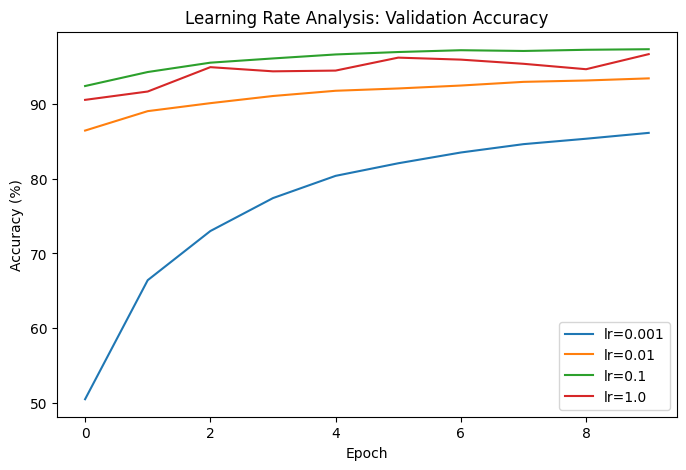

In [236]:
for lr in learning_rates:
    print(f"\n==== Training with Learning Rate = {lr} ====")
    model = ForwardNN()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, training_loader, validation_loader, criterion, optimizer, num_epochs=10
    )
    results_lr[lr] = (train_losses, val_losses, train_accs, val_accs)

plt.figure(figsize=(8, 5))
for lr, (_, _, _, val_accs) in results_lr.items():
    plt.plot(val_accs, label=f"lr={lr}")
plt.title("Learning Rate Analysis: Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [237]:
batch_sizes = [16, 32, 64, 128]
results_bs = []


==== Training with Batch Size = 16 ====
Epoch [1/10] Train Loss=0.5571, Val Loss=0.3118, Train Acc=85.05%, Val Acc=91.28%
Epoch [2/10] Train Loss=0.2644, Val Loss=0.2595, Train Acc=92.30%, Val Acc=92.36%
Epoch [3/10] Train Loss=0.2113, Val Loss=0.2054, Train Acc=93.84%, Val Acc=94.10%
Epoch [4/10] Train Loss=0.1762, Val Loss=0.1793, Train Acc=94.94%, Val Acc=94.71%
Epoch [5/10] Train Loss=0.1507, Val Loss=0.1558, Train Acc=95.70%, Val Acc=95.21%
Epoch [6/10] Train Loss=0.1316, Val Loss=0.1444, Train Acc=96.25%, Val Acc=95.67%
Epoch [7/10] Train Loss=0.1160, Val Loss=0.1340, Train Acc=96.71%, Val Acc=95.87%
Epoch [8/10] Train Loss=0.1026, Val Loss=0.1262, Train Acc=97.10%, Val Acc=96.33%
Epoch [9/10] Train Loss=0.0918, Val Loss=0.1158, Train Acc=97.36%, Val Acc=96.59%
Epoch [10/10] Train Loss=0.0830, Val Loss=0.1132, Train Acc=97.67%, Val Acc=96.46%

==== Training with Batch Size = 32 ====
Epoch [1/10] Train Loss=0.7764, Val Loss=0.3959, Train Acc=80.31%, Val Acc=89.32%
Epoch [2/10] Tr

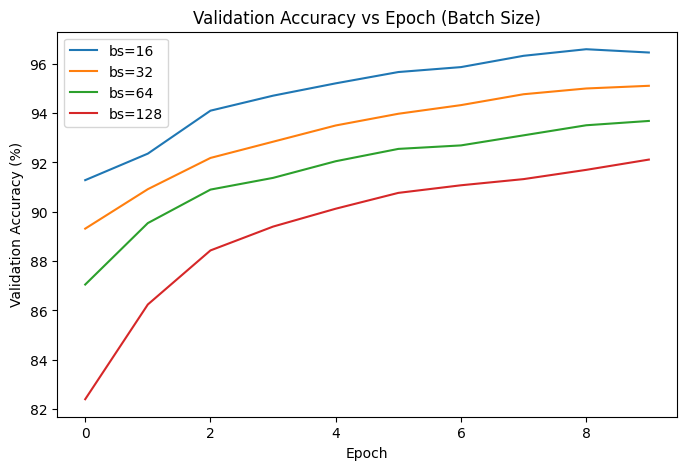

In [238]:
plt.figure(figsize=(8, 5))
for bs in batch_sizes:
    print(f"\n==== Training with Batch Size = {bs} ====")
    train_loader = DataLoader(trainig_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)

    model = ForwardNN()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=10
    )
    elapsed = time.time() - start_time

    results_bs.append((bs, val_accs[-1], round(elapsed, 1)))

    plt.plot(val_accs, label=f'bs={bs}')

plt.title('Validation Accuracy vs Epoch (Batch Size)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

In [239]:
# create a summary table
batch_results_df = pd.DataFrame(
    results_bs, columns=['Batch Size', 'Final Val Accuracy (%)', 'Training Time (s)']
)

print("\nBatch Size Comparison:")
print(batch_results_df)


Batch Size Comparison:
   Batch Size  Final Val Accuracy (%)  Training Time (s)
0          16               96.458333               34.5
1          32               95.108333               57.1
2          64               93.683333               18.6
3         128               92.116667                7.6


## Architecture Analysis

In [240]:
layer_configs = [2, 3, 4, 5]
neurons = [64, 128, 256, 512]
arch_results = []


==== Testing 2 Hidden Layers with 64 Neurons ====
Epoch [1/10] Train Loss=2.1075, Val Loss=1.6683, Train Acc=40.91%, Val Acc=67.02%
Epoch [2/10] Train Loss=1.0302, Val Loss=0.6681, Train Acc=77.07%, Val Acc=82.07%
Epoch [3/10] Train Loss=0.5497, Val Loss=0.4864, Train Acc=84.97%, Val Acc=86.55%
Epoch [4/10] Train Loss=0.4381, Val Loss=0.4203, Train Acc=87.80%, Val Acc=88.49%
Epoch [5/10] Train Loss=0.3861, Val Loss=0.3827, Train Acc=89.04%, Val Acc=89.22%
Epoch [6/10] Train Loss=0.3549, Val Loss=0.3575, Train Acc=89.89%, Val Acc=90.00%
Epoch [7/10] Train Loss=0.3326, Val Loss=0.3403, Train Acc=90.41%, Val Acc=90.32%
Epoch [8/10] Train Loss=0.3160, Val Loss=0.3326, Train Acc=90.83%, Val Acc=90.74%
Epoch [9/10] Train Loss=0.3022, Val Loss=0.3123, Train Acc=91.29%, Val Acc=91.16%
Epoch [10/10] Train Loss=0.2906, Val Loss=0.3065, Train Acc=91.59%, Val Acc=91.32%

==== Testing 2 Hidden Layers with 128 Neurons ====
Epoch [1/10] Train Loss=2.0251, Val Loss=1.4251, Train Acc=49.28%, Val Acc=7

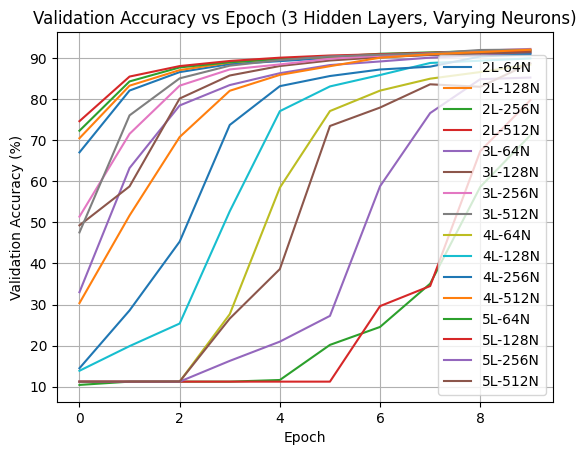

In [241]:
for num_layers in layer_configs:
    for n in neurons:
        print(f"\n==== Testing {num_layers} Hidden Layers with {n} Neurons ====")

        layers = []
        input_size = 784
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, n))
            layers.append(nn.ReLU())
            input_size = n
        layers.append(nn.Linear(input_size, 10))
        model = nn.Sequential(*layers)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, training_loader, validation_loader, criterion, optimizer, num_epochs=10
        )
        elapsed = time.time() - start_time

        arch_results.append([num_layers, n, val_accs[-1], round(elapsed, 1)])
        plt.plot(val_accs, label=f"{num_layers}L-{n}N")

# Plot setup
plt.title('Validation Accuracy vs Epoch (3 Hidden Layers, Varying Neurons)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [242]:
arch_df = pd.DataFrame(
    arch_results,
    columns=["Hidden Layers", "Neurons", "Val Accuracy (%)", "Training Time (s)"]
)

print("\nArchitecture Comparison Table:")
print(arch_df)


Architecture Comparison Table:
    Hidden Layers  Neurons  Val Accuracy (%)  Training Time (s)
0               2       64         91.316667                8.0
1               2      128         91.516667               33.4
2               2      256         91.841667               14.6
3               2      512         91.775000               13.1
4               3       64         91.091667               17.1
5               3      128         91.325000                9.1
6               3      256         92.191667               11.9
7               3      512         92.041667               18.2
8               4       64         88.383333                9.3
9               4      128         89.883333               10.2
10              4      256         90.875000               13.5
11              4      512         91.991667               20.3
12              5       64         71.175000               10.1
13              5      128         79.725000               11.2
14      

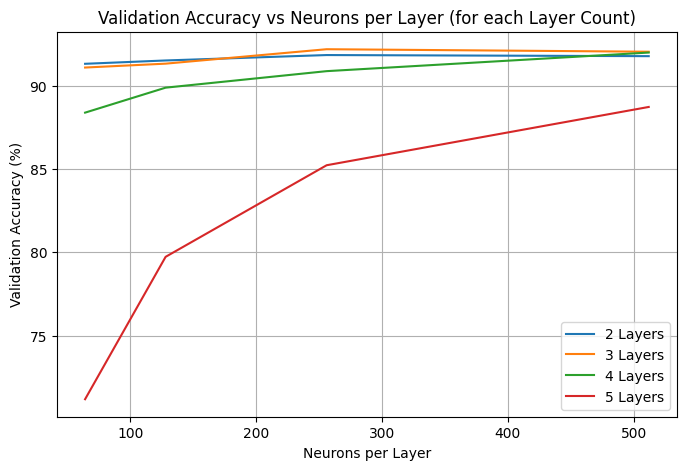

In [245]:
plt.figure(figsize=(8,5))
for num_layers in layer_configs:
    subset = arch_df[arch_df["Hidden Layers"] == num_layers]
    plt.plot(subset["Neurons"], subset["Val Accuracy (%)"], label=f"{num_layers} Layers")

plt.title("Validation Accuracy vs Neurons per Layer (for each Layer Count)")
plt.xlabel("Neurons per Layer")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

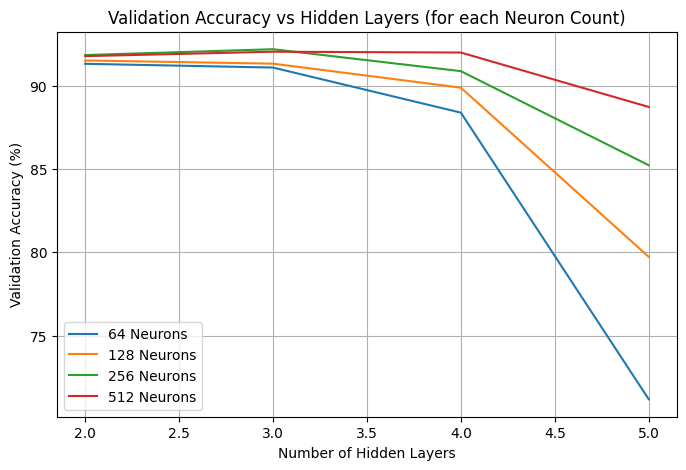

In [246]:
plt.figure(figsize=(8,5))
for n in neurons:
    subset = arch_df[arch_df["Neurons"] == n]
    plt.plot(subset["Hidden Layers"], subset["Val Accuracy (%)"], label=f"{n} Neurons")

plt.title("Validation Accuracy vs Hidden Layers (for each Neuron Count)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

## Comparative Analysis

In [247]:
comparison_data = {
    "Model": ["Logistic Regression", "Softmax Regression", "Best Neural Network"],
    "Test Accuracy (%)": [91.98, 91.98, max(arch_df["Val Accuracy (%)"])],
    "Training Time (s)": [8.59, 8.36, arch_df["Training Time (s)"].min()]
}

In [248]:
comparison_df = pd.DataFrame(comparison_data)
print("\n=== Model Comparison Summary ===")
print(comparison_df)


=== Model Comparison Summary ===
                 Model  Test Accuracy (%)  Training Time (s)
0  Logistic Regression          91.980000               8.59
1   Softmax Regression          91.980000               8.36
2  Best Neural Network          92.191667               8.00


## Best Model Evaluation

In [249]:
# Identify and rebuild the best architecture from Architecture Analysis
best_idx = arch_df["Val Accuracy (%)"].idxmax()
best_layers = int(arch_df.loc[best_idx, "Hidden Layers"])
best_neurons = int(arch_df.loc[best_idx, "Neurons"])
print(f"\n=== Best Architecture Found ===")
print(f"Hidden Layers: {best_layers} | Neurons per Layer: {best_neurons}")


=== Best Architecture Found ===
Hidden Layers: 3 | Neurons per Layer: 256


In [250]:
# Dynamically build the best network
layers = []
input_size = 784
for _ in range(best_layers):
    layers.append(nn.Linear(input_size, best_neurons))
    layers.append(nn.ReLU())
    input_size = best_neurons

In [251]:
layers.append(nn.Linear(input_size, 10))

In [252]:
best_model = nn.Sequential(*layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(best_model.parameters(), lr=0.01)

In [253]:
# Train the best model silently (no printed results or returned arrays)
print("\nTraining Best Model...")
_ = train_model(best_model, training_loader, validation_loader, criterion, optimizer, num_epochs=15)


Training Best Model...
Epoch [1/15] Train Loss=2.2794, Val Loss=2.2361, Train Acc=26.66%, Val Acc=52.58%
Epoch [2/15] Train Loss=1.9174, Val Loss=1.2754, Train Acc=53.63%, Val Acc=69.67%
Epoch [3/15] Train Loss=0.8276, Val Loss=0.5941, Train Acc=77.74%, Val Acc=83.24%
Epoch [4/15] Train Loss=0.5044, Val Loss=0.4589, Train Acc=85.62%, Val Acc=87.08%
Epoch [5/15] Train Loss=0.4145, Val Loss=0.4054, Train Acc=88.11%, Val Acc=88.40%
Epoch [6/15] Train Loss=0.3720, Val Loss=0.3671, Train Acc=89.31%, Val Acc=89.60%
Epoch [7/15] Train Loss=0.3421, Val Loss=0.3407, Train Acc=90.20%, Val Acc=90.37%
Epoch [8/15] Train Loss=0.3190, Val Loss=0.3205, Train Acc=90.69%, Val Acc=90.88%
Epoch [9/15] Train Loss=0.2987, Val Loss=0.3058, Train Acc=91.36%, Val Acc=91.34%
Epoch [10/15] Train Loss=0.2807, Val Loss=0.2886, Train Acc=91.95%, Val Acc=91.88%
Epoch [11/15] Train Loss=0.2636, Val Loss=0.2731, Train Acc=92.38%, Val Acc=92.20%
Epoch [12/15] Train Loss=0.2484, Val Loss=0.2634, Train Acc=92.74%, Val 

In [282]:
# Evaluate on the test set
best_model.eval()
correct, total = 0, 0
preds_list, labels_list = [], []

In [288]:
start_time = time.time()
with torch.no_grad():
    for images, labels in testing_loader:
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)
elapsed = time.time() - start_time

In [289]:
# Compute final test accuracy
test_acc = 100 * correct / total
print(f"\nFinal Test Accuracy (Best Neural Network): {test_acc:.2f}%")


Final Test Accuracy (Best Neural Network): 93.46%


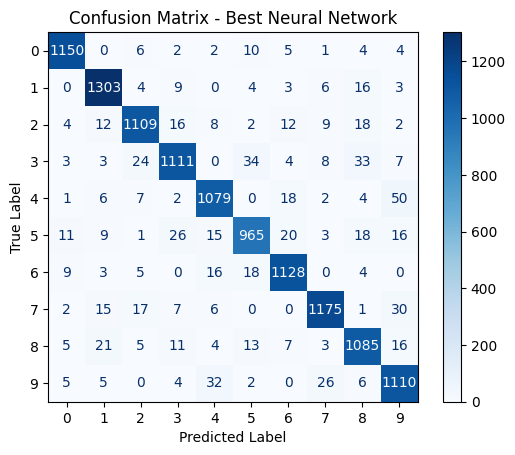

In [285]:
# Compute and plot confusion matrix
cm = confusion_matrix( np.array(labels_list), np.array(preds_list))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=True)
plt.title("Confusion Matrix - Best Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [286]:
# Display some misclassified samples
misclassified_indices = [i for i, (p, t) in enumerate(zip(preds_list, labels_list)) if p != t]

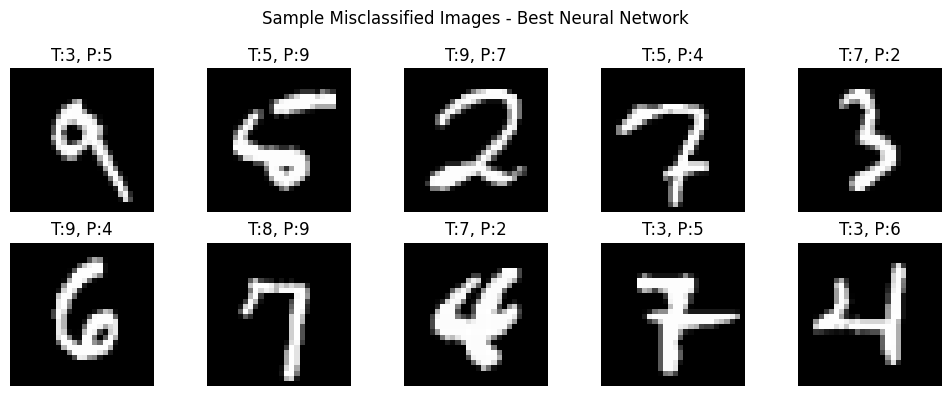

In [287]:
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_test.data[idx], cmap='gray')
    plt.title(f"T:{labels_list[idx]}, P:{preds_list[idx]}")
    plt.axis('off')

plt.suptitle("Sample Misclassified Images - Best Neural Network")
plt.tight_layout()
plt.show()

## Bouns

## CNN

In [92]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cn2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self, x):
        x=x.view(-1,1,28,28)
        x = self.cn1(x)
        x = self.cn2(x)
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

In [93]:
modelCNN= CNN()
tl,vl,ta,va=train(modelCNN,30)

Epoch [1/30] Train Loss: 1.7709, Val Loss: 0.6336, Train Acc: 80.15%, Val Acc: 80.02%
Epoch [2/30] Train Loss: 0.4097, Val Loss: 0.3581, Train Acc: 89.54%, Val Acc: 89.12%
Epoch [3/30] Train Loss: 0.2622, Val Loss: 0.2572, Train Acc: 92.36%, Val Acc: 92.08%
Epoch [4/30] Train Loss: 0.1964, Val Loss: 0.1922, Train Acc: 94.31%, Val Acc: 93.81%
Epoch [5/30] Train Loss: 0.1595, Val Loss: 0.1522, Train Acc: 95.59%, Val Acc: 95.27%
Epoch [6/30] Train Loss: 0.1336, Val Loss: 0.1320, Train Acc: 96.27%, Val Acc: 95.92%
Epoch [7/30] Train Loss: 0.1179, Val Loss: 0.1175, Train Acc: 96.87%, Val Acc: 96.62%
Epoch [8/30] Train Loss: 0.1047, Val Loss: 0.1245, Train Acc: 96.25%, Val Acc: 96.24%
Epoch [9/30] Train Loss: 0.0961, Val Loss: 0.0934, Train Acc: 97.46%, Val Acc: 97.09%
Epoch [10/30] Train Loss: 0.0885, Val Loss: 0.0927, Train Acc: 97.42%, Val Acc: 97.19%
Epoch [11/30] Train Loss: 0.0825, Val Loss: 0.0998, Train Acc: 97.32%, Val Acc: 97.07%
Epoch [12/30] Train Loss: 0.0772, Val Loss: 0.0797, 

In [95]:
test_acc = calculate_accuracy(modelCNN, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 98.10%


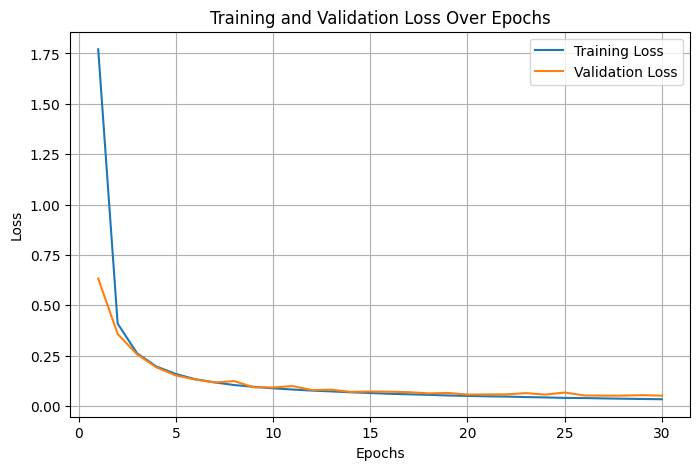

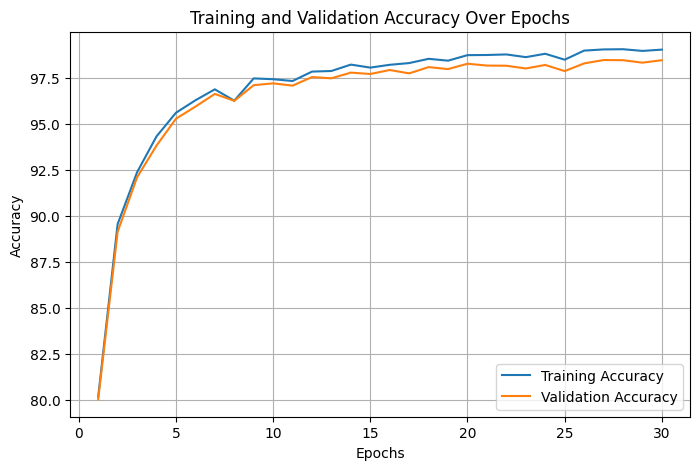

In [96]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

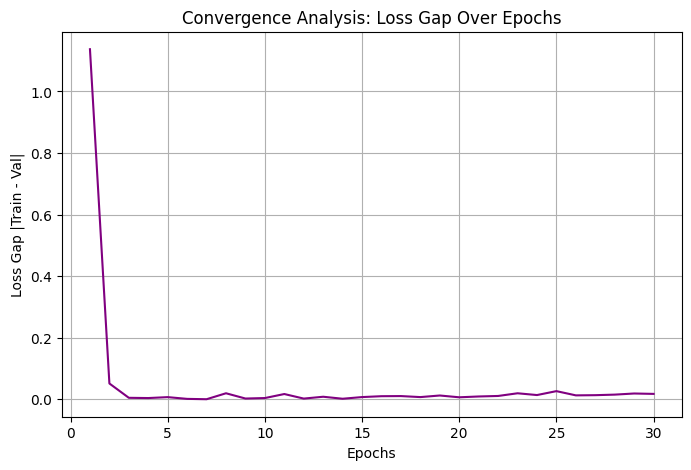

In [97]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

# Comparison
NN 96-97 %
CNN 98-99%
Convolutional Neural Networks preserve the 2D image structure and learn spatial features
Fully-connected networks flatten the image and lose spatial relationships, making them less efficient for vision tasks.